In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

def make_bands_x(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
 
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem fro all k
    for j, k in enumerate(momenta):
        parameters['kx'] = k
        Phi, H, P, deleted_indices = operators_ribbon(parameters)
        bands[j] = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-2, sigma = 0.001, which = 'LM',return_eigenvectors = False)

    return momenta,bands

In [2]:
def operators_ribbon(parameters, plot_potential = False, plot_mass = False, plot_mag_field = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (should be odd)
    Ny = parameters['Ny']     # Number of unit cells in y direction (should be odd)
    kx = parameters['kx']
    ky = parameters['ky']
    
    #Generate Peierls phases
    #np.random.seed(0)
    if parameters['B1'] == 0:
        a_e = np.zeros((Ny,Nx))
        a_n = np.zeros((Ny,Nx))
    else:
        fluxes = tb.make_fluxes(parameters, plot = plot_mag_field)
        a_e, a_n = tb.vector_potential(parameters,fluxes)
        
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Peierls phases
        p_e = np.exp(1j*(a_e[y,x]))
        p_n = np.exp(1j*(a_n[y,x]))
        
        #Standard translations
        trs_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        trs_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        #Total phases
        phase_e = p_e*trs_e
        phase_n = p_n*trs_n
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e]
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    potential_array = tb.make_potential(parameters, plot = plot_potential).flatten()    
    pot = scipy.sparse.spdiags(potential_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    V = scipy.sparse.kron(csc_matrix(sigma_0), pot, format = "csc")    
    
    mass_array = tb.make_mass(parameters, plot = plot_mass).flatten()    
    mass = scipy.sparse.spdiags(mass_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@V@Phi + Phi.H@M@Phi
    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']
    for x in range(Nx):
        rotation = spin_rotation([x,0], theta,0)
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
    for x in range(Nx):
        rotation = spin_rotation([x,Ny-1], pi-theta, np.pi)
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
    
    ####
    
    indices_to_delete = []#sites and spins on the edge. bot_bound and top_bound must be 0 or 1 to pick spin
    
    for x in range(Nx):
        indices_to_delete.append(Nx*Ny + int(x)) #bottom edge
        indices_to_delete.append(int((Nx*Ny + Nx*(Ny-1) + x))) #top edge
  
        
    # Transforming the sparse matrix into dense to delete spins is probably not the best way to do this
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi
    
    return Phi, H, P, indices_to_delete

In [39]:
thetas = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

i = 0 ### selected value of theta
Nx = 3
Ny = 15
nbands = 40

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    B1 = 0, # no magnetic field
    N1 = 0, #
    d1 = 0, # These are irrelevant for B1 = 0
    N2 = 0, #
    potential = lambda x,y:0.0*np.random.rand(Ny,Nx),
    mass = lambda x,y:0*x,
    disorder = 0,
    theta = -(pi/2)*(thetas[i]/100),
    ky = 0,
)

momenta, bands = make_bands_x(parameters,number_of_bands = nbands, number_of_points = int(501),kmin = -1, kmax = 1)

(-3.141592653589793, 3.141592653589793)

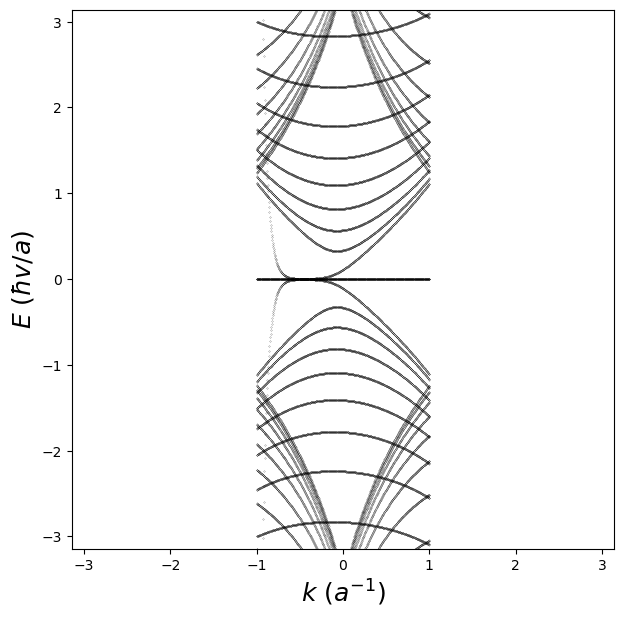

In [40]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
ax.set_ylim(-pi,pi)
ax.set_xlim(-pi,pi)
#ax.set_xlim(-pi/np.sqrt(2),pi/np.sqrt(2))
#fig.savefig('diagonal_antizigzag_small.pdf')